## Functional validation of PR#394 acquisition box overlap penalty

This evaluates the impact [PR#394](https://github.com/sot/proseco/pull/394) of adding an
overlap penalty to proseco acquisition star selection.

The data set consists of 641 star catalogs covering DEC2523B through MAR0624A. For each
catalog the star catalog is reselected using the development version of proseco in two
ways:
1. With no overlap penalty, effectively matching the current flight code.
2. With an overlap penalty applied, matching the proposed new default.

The overlap penalty consists of multiplying the existing acquisition probability by 0.7.
This is derived from statistics for the acquisition success of bright stars that have
an overlapping search box with a fainter star. The value of 0.7 is the worst case.

Summary:
- About 38% of selected catalogs are different when the penalty is applied. Most of the
  differences are either beneficial or non-impacting (e.g. a change in a search box from
  160 to 140 arcsec).
- 113 of 641 (18%) of catalogs show a substantial improvement of > 0.25 in P2. This is
  largely due to avoiding overlaps.
- 2 of 641 catalogs showed a noticable decrease (worse) in P2, with the worst case being
  a decrease from about 7.2 to 6.6. This is acceptable.
  

In [1]:
import gzip
import pickle
import sys
from pathlib import Path

sys.path.insert(0, str(Path.home() / "git" / "proseco"))

import kadi.commands as kc
import matplotlib.pyplot as plt
import numpy as np
import parse_cm.paths
import ska_helpers.utils
from astropy.table import Table
from tqdm import tqdm

from proseco import get_aca_catalog
from proseco.diff import catalog_diff

%matplotlib inline

In [2]:
import proseco

print(proseco.__version__)

5.12.1.dev15+gfbf13c0.d20240313


In [3]:
obss = kc.get_observations("2024:001", "2024:070")
len(obss)

521

In [4]:
obss = [obs for obs in obss if obs.get("starcat_idx")]
len(obss)

473

In [5]:
load_names = {obs["source"] for obs in obss}

In [6]:
load_names

{'DEC2523B',
 'FEB0724A',
 'FEB1124A',
 'FEB1924A',
 'FEB2624A',
 'JAN0824A',
 'JAN1524B',
 'JAN2224A',
 'JAN2324B',
 'JAN2624A',
 'JAN2924A',
 'MAR0424A',
 'MAR0624A'}

In [7]:
obsids_example = {28194}
results = {}

In [8]:
rows = []
for load_name in load_names:
    path_pkl = parse_cm.paths.load_file_path(load_name, "output/*.pkl.gz")
    acas = pickle.load(gzip.open(path_pkl, "rb"))
    for aca in tqdm(acas.values()):
        with ska_helpers.utils.temp_env_var("PROSECO_DISABLE_OVERLAP_PENALTY", "False"):
            aca_penalty = get_aca_catalog(**aca.call_args)
        with ska_helpers.utils.temp_env_var("PROSECO_DISABLE_OVERLAP_PENALTY", "True"):
            aca_no_penalty = get_aca_catalog(**aca.call_args)
            p2_no_penalty_at_all = -np.log10(aca_no_penalty.acqs.calc_p_safe())
        if aca.obsid in obsids_example:
            results[aca.obsid] = {
                "aca": aca,
                "aca_penalty": aca_penalty,
                "aca_no_penalty": aca_no_penalty,
            }
        diff = bool(catalog_diff(aca_penalty, aca_no_penalty, style="unified").text)
        p2_penalty = -np.log10(aca_penalty.acqs.calc_p_safe())
        p2_no_penalty = -np.log10(aca_no_penalty.acqs.calc_p_safe())
        overlaps = np.any(aca.acqs.get_overlap_penalties() != 1.0)
        overlaps_penalty = np.any(aca_penalty.acqs.get_overlap_penalties() != 1.0)
        rows.append(
            (
                load_name,
                aca.obsid,
                diff,
                p2_penalty,
                p2_no_penalty,
                p2_no_penalty_at_all,
                overlaps,
                overlaps_penalty,
            )
        )
stats = Table(
    rows=rows,
    names=[
        "load_name",
        "obsid",
        "diff",
        "p2_penalty",
        "p2_no_penalty",
        "p2_no_penalty_at_all",
        "overlaps_orig",
        "overlaps_penalty",
    ],
)

100%|██████████| 58/58 [00:33<00:00,  1.72it/s]


In [9]:
def plot_print(aca, title):
    print(title)
    print(f"P2 = {-np.log10(aca.acqs.calc_p_safe()):.2f}")
    aca.plot()

No overlap penalty
P2 = 2.03


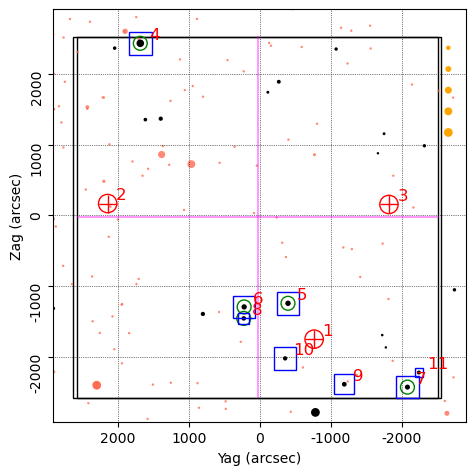

In [10]:
plot_print(results[28194]["aca_no_penalty"], "No overlap penalty")

With overlap penalty
P2 = 2.48


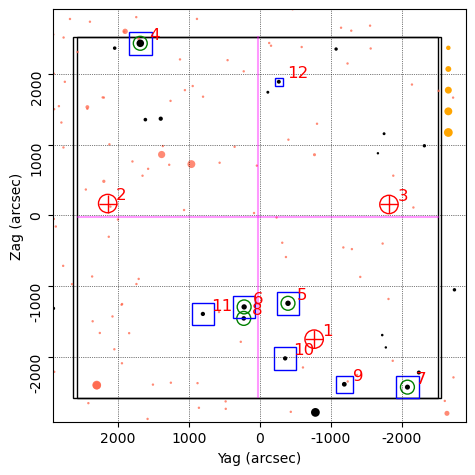

In [11]:
plot_print(results[28194]["aca_penalty"], "With overlap penalty")

In [12]:
catalog_diff(results[28194]["aca_no_penalty"], results[28194]["aca_penalty"])

f,1,idx id slot type mag sz dim res halfw,f,1,idx id slot type mag sz dim res halfw
,2,--- --------- ---- ---- ----- --- --- --- -----,,2,--- --------- ---- ---- ----- --- --- --- -----
,3,1 2 0 FID 7.00 8x8 1 1 25,,3,1 2 0 FID 7.00 8x8 1 1 25
,4,2 4 1 FID 7.00 8x8 1 1 25,,4,2 4 1 FID 7.00 8x8 1 1 25
,5,3 5 2 FID 7.00 8x8 1 1 25,,5,3 5 2 FID 7.00 8x8 1 1 25
,6,--- --------- ---- ---- ----- --- --- --- -----,,6,--- --------- ---- ---- ----- --- --- --- -----
n,7,8 117707288 7 GU* 9.96 8x8 1 1 25,n,7,8 117707288 7 GUI 9.96 8x8 1 1 25
,8,6 117707912 5 GU* 9.38 8x8 1 1 25,,8,6 117707912 5 GU* 9.38 8x8 1 1 25
,9,5 117707920 4 GU* 9.33 8x8 1 1 25,,9,5 117707920 4 GU* 9.33 8x8 1 1 25
,10,4 117708000 3 GU* 7.39 8x8 1 1 25,,10,4 117708000 3 GU* 7.39 8x8 1 1 25
,11,7 117837584 6 GU* 9.60 8x8 1 1 25,,11,7 117837584 6 GU* 9.60 8x8 1 1 25


In [18]:
def plot_compare(stats, compare_key="p2_no_penalty", label="P2 no penalty (selection)"):
    overlaps = stats["overlaps_orig"]
    plt.plot([1.5, 9], [1.5, 9], "k--", alpha=0.2)
    plt.plot(
        stats[compare_key][overlaps],
        stats["p2_penalty"][overlaps],
        "r*",
        label="Overlaps",
    )
    plt.plot(
        stats[compare_key][~overlaps],
        stats["p2_penalty"][~overlaps],
        ".",
        label="No overlaps",
    )
    overlaps = stats["overlaps_penalty"]
    if np.any(overlaps):
        plt.plot(
            stats[compare_key][overlaps],
            stats["p2_penalty"][overlaps],
            "k+",
            ms=8,
            label="Overlaps with penalty",
        )
    plt.grid("on")
    plt.xlabel(label)
    plt.ylabel("P2 with penalty")
    plt.legend()

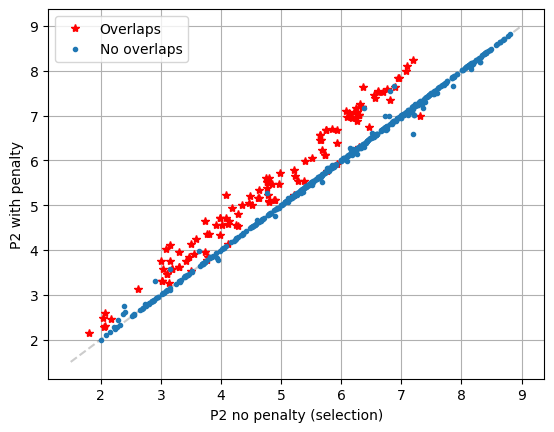

In [19]:
plot_compare(stats)

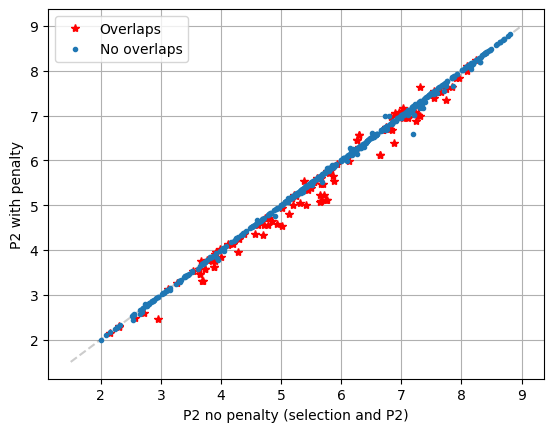

In [20]:
plot_compare(stats, "p2_no_penalty_at_all", "P2 no penalty (selection and P2)")

In [14]:
n_cats = len(stats)
n_cats

641

In [15]:
np.count_nonzero(stats["diff"]) / n_cats

0.3790951638065523

In [16]:
print(np.count_nonzero(stats["p2_penalty"] - stats["p2_no_penalty"] > 0.25))
print(np.count_nonzero(stats["p2_penalty"] - stats["p2_no_penalty"] > 0.25) / n_cats)

113
0.17628705148205928


In [17]:
np.count_nonzero(stats["p2_penalty"] - stats["p2_no_penalty"] < -0.25)

2